# Modeling

For our evaluation metric, we want to use RMSE. RMSE allows us to view the model's error in terms of the target's unit, making it easier to understand. 

We do intend to use clusters in some of our models, but I'm curious to see how the model performs without the clusters first. When all models have been run, we will compare them to see if the clusters we created improve our models.

For the models we will create for our MVP, the features we will be using are `tax_value`, `age`, `sq_ft`, and the clusters we created.

In [1]:
# imports
import wrangle_stewart_01 as wr
import pandas as pd
# turn off pink warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# wrangle data
train, validate, test = wr.split_data(wr.remove_outliers(wr.wrangle_zillow(0.6, 0.8), ['sq_ft', 'baths', 'beds',
                        'fullbaths', 'tax_value'], 1.5))
# standard scale data
train, validate, test = wr.standard_scale_data(train, validate, test, ['baths', 'beds', 'sq_ft', 'tax_value', 'age'])
train.shape, validate.shape, test.shape

((35820, 19), (15352, 19), (12793, 19))

In [3]:
# preview data
train.head()

,baths,beds,sq_ft,fips,fullbaths,latitude,longitude,rooms,yearbuilt,tax_value,logerror,transactiondate,fips_loc,age,baths_scaled,beds_scaled,sq_ft_scaled,tax_value_scaled,age_scaled
18818,3.0,3.0,1683.0,6037,3.0,33874056.0,-118365638.0,0.0,1986.0,331062.0,-0.009760,2017-03-21,"Los Angeles, CA",36.0,1.247680,0.099184,0.208523,-0.135195,-0.770150
52227,2.0,3.0,1085.0,6037,2.0,34616142.0,-117811587.0,0.0,1987.0,109644.0,-0.023405,2017-06-30,"Los Angeles, CA",35.0,-0.154243,0.099184,-0.821472,-1.143307,-0.814908
25353,3.0,3.0,2030.0,6037,3.0,34135615.0,-118502375.0,0.0,1966.0,127529.0,-0.009772,2017-04-11,"Los Angeles, CA",56.0,1.247680,0.099184,0.806196,-1.061877,0.125017
73264,2.0,3.0,1652.0,6059,2.0,33945258.0,-117942079.0,7.0,1959.0,180075.0,-0.021081,2017-09-01,"Orange, CA",63.0,-0.154243,0.099184,0.155128,-0.822636,0.438326
56877,2.0,3.0,1684.0,6037,2.0,34212322.0,-118214747.0,0.0,1942.0,81966.0,-0.006403,2017-07-14,"Los Angeles, CA",80.0,-0.154243,0.099184,0.210245,-1.269324,1.199217


In [4]:
# view summary stats for target
train.logerror.describe()

count    35820.000000
mean         0.014648
std          0.157703
min         -4.655420
25%         -0.023550
50%          0.005932
75%          0.035647
max          3.394544
Name: logerror, dtype: float64

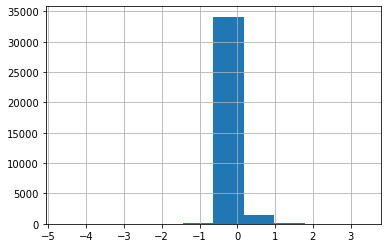

In [5]:
# view logerror distribution
train.logerror.hist();

To establish a baseline, I want to use median rather than mean. Looking at the histogram and summary statistics above, the median seems to be more representative of the data than mean.

In [6]:
# establish baseline
baseline = train.logerror.median()
baseline

0.0059316654231650005

In [7]:
# split data into x and y
scaled_cols = ['tax_value_scaled', 'age_scaled', 'sq_ft_scaled']

x_train = train[scaled_cols]
y_train = train.logerror

x_validate = validate[scaled_cols]
y_validate = validate.logerror

In [8]:
# import eval metric
from sklearn.metrics import mean_squared_error

# evaluate baseline
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

y_train['baseline'] = baseline
y_validate['baseline'] = baseline

rmse_train = mean_squared_error(y_train.logerror, y_train.baseline)**0.5
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.baseline)**0.5

print('Baseline(median `logerror`) RMSE')
print(f'Train: {rmse_train}')
print(f'Validate: {rmse_validate}')

Baseline(median `logerror`) RMSE
Train: 0.15794177457620232
Validate: 0.15517607692395097


In [9]:
# run ols model (without clusters)
from sklearn.linear_model import LinearRegression

# create object
lm = LinearRegression(normalize=True)
# fit model to train
lm.fit(x_train, y_train.logerror)
# train predictions
y_train['ols_pred'] = lm.predict(x_train)
# evaluate model on train
rmse_train_ols = mean_squared_error(y_train.logerror, y_train.ols_pred)**0.5
# validate predictions
y_validate['ols_pred'] = lm.predict(x_validate)
# evaluate model on validate
rmse_validate_ols = mean_squared_error(y_validate.logerror, y_validate.ols_pred)**0.5

# print results
print(f'OLS RMSE Train: {rmse_train_ols}')
print(f'OLS RMSE Validate: {rmse_validate_ols}')

OLS RMSE Train: 0.1575445762277908
OLS RMSE Validate: 0.15475016447694118


In [10]:
# run lassolars without clusters
from sklearn.linear_model import LassoLars

# create object
lars = LassoLars()
# fit model to train
lars.fit(x_train, y_train.logerror)
# make predictions on train
y_train['ll_pred'] = lars.predict(x_train)
# evaluate model on train
rmse_train_ll = mean_squared_error(y_train.logerror, y_train.ll_pred)**0.5
# validate predictions
y_validate['ll_pred'] = lars.predict(x_validate)
# evaluate model on validate
rmse_validate_ll = mean_squared_error(y_validate.logerror, y_validate.ll_pred)**0.5

# print results
print(f'LassoLars RMSE Train: {rmse_train_ll}')
print(f'LassoLars RMSE Validate: {rmse_validate_ll}')

LassoLars RMSE Train: 0.1577010506631275
LassoLars RMSE Validate: 0.15488023191149203


In [11]:
# run polynomial without clusters
from sklearn.preprocessing import PolynomialFeatures

# create polynomial features object
poly_feat = PolynomialFeatures()
# fit/transform object on train
x_train_poly = poly_feat.fit_transform(x_train)
# transform on validate and test
x_validate_poly = poly_feat.transform(x_validate)

# create model object
plm = LinearRegression(normalize=True)
# fit model to train
plm.fit(x_train_poly, y_train.logerror)
# make predictions on train
y_train['poly_pred'] = plm.predict(x_train_poly)
# evaluate model on train
rmse_train_poly = mean_squared_error(y_train.logerror, y_train.poly_pred)**0.5
# validate predictions
y_validate['poly_pred'] = plm.predict(x_validate_poly)
# evaluate model on validate
rmse_validate_poly = mean_squared_error(y_validate.logerror, y_validate.poly_pred)**0.5

# print results
print(f'Polynomial Regression RMSE Train: {rmse_train_poly}')
print(f'Polynomial Regression RMSE Validate: {rmse_validate_poly}')

Polynomial Regression RMSE Train: 0.1574469261544694
Polynomial Regression RMSE Validate: 0.1546330921790841


In [12]:
# view results as dataframe
rmse = pd.DataFrame({'Linear Regression':[rmse_train_ols, rmse_validate_ols, (rmse_train_ols-rmse_validate_ols)],
                    'LassoLars':[rmse_train_ll, rmse_validate_ll, (rmse_train_ll-rmse_validate_ll)],
                    'Polynomial':[rmse_train_poly, rmse_validate_poly, (rmse_train_poly-rmse_validate_poly)],
                    'Baseline':[rmse_train, rmse_validate, (rmse_train-rmse_validate)]},
                    index=['train', 'validate', 'difference'])
rmse

,Linear Regression,LassoLars,Polynomial,Baseline
train,0.157545,0.157701,0.157447,0.157942
validate,0.154750,0.154880,0.154633,0.155176
difference,0.002794,0.002821,0.002814,0.002766


**Takeaways:**
- Without using any of the clusters we made in exploration, the Polynomial Regression model appears to perform best. 
 - This model has the lowest RMSE for both train and validate, and it has the smallest difference between train/validate RMSE. 
- All of the models created so far in this notebook have beaten the baseline (median logerror) by a very small margin.

In [13]:
# use selectkbest to get top features
from sklearn.feature_selection import SelectKBest, f_regression
# set parameters for f_selector object
f_selector = SelectKBest(f_regression, k=2)
# fit object to data
f_selector.fit(x_train, y_train.logerror)
# get bool mask of features list
f_mask = f_selector.get_support()
# get list of features (True)
f_feature = x_train.iloc[:,f_mask].columns.tolist()
f_feature

['tax_value_scaled', 'sq_ft_scaled']

In [14]:
X_train, X_validate, X_test, X_train_scaled, X_validate_scaled, X_test_scaled = wr.scale_and_cluster(train, validate, test, ['sq_ft', 'tax_value', 'age'], ['beds', 'baths', 'sq_ft'], 4)

In [15]:
X_train_scaled

,sq_ft,tax_value,age,cluster
0,0.208523,-0.135195,-0.770150,1
1,-0.821472,-1.143307,-0.814908,1
2,0.806196,-1.061877,0.125017,3
3,0.155128,-0.822636,0.438326,1
4,0.210245,-1.269324,1.199217,1
...,...,...,...,...
35815,-0.795636,0.055748,-0.814908,1
35816,-0.375371,2.051688,2.139142,0
35817,-0.523497,-1.433437,0.930667,0
35818,-1.658559,-0.979459,-0.456841,0
